<a href="https://colab.research.google.com/github/FKz11/NN_PyTorch/blob/main/lesson_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lesson-6

### Библиотеки:

In [1]:
pip install -qq stop-words

In [2]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download("punkt")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from string import ascii_lowercase
from stop_words import get_stop_words
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

## 1. Подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

### Данные

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/archive.zip'

In [6]:
df = pd.read_csv('/content/train.csv')
df.drop('id', axis=1, inplace=True)
df.tail()

,label,tweet
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."
31961,0,thank you @user for you follow


#### train_test_split

In [7]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

train_df.tail()

,label,tweet
22368,0,#waltdisneyreso should be ashamed of themselv...
22369,0,@user invited @user over for a catch up and i...
22370,1,black professor makes assumptions about an ent...
22371,0,#lgbtqhatetrumppay is total #liberal trash. it...
22372,0,what makes people is relative. we have our w...


In [8]:
train_df['label'].value_counts()

0    20815
1     1558
Name: label, dtype: int64

In [9]:
disbalance = train_df['label'].value_counts()[0] / train_df['label'].value_counts()[1]
disbalance

13.36007702182285

Видно, что у нас есть сильный дизбаланс классов

### Предобработка

Стоп слова, которые не несут большой смысловой нагрузки

In [10]:
sw = set(get_stop_words('en'))
sw

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "s

Уберём из них отрицание, так как, допустим, оно несёт смысл

In [11]:
sw.remove('not')
sw.remove('nor')
sw.remove('no')

Обозначим возможные символы

In [12]:
ascii_plus = ascii_lowercase + "' "
ascii_plus

"abcdefghijklmnopqrstuvwxyz' "

Попробуем развернуть сокращения с отрицанием, чтобы его оттуда вытянуть

In [13]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "can not",
"can't've": "can not have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"isn't": "is not",
"mayn't": "may not",
"mightn't": "might not",
"mightn't've": "might not have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"wasn't": "was not",
"weren't": "were not",
"won't": "will not",
"won't've": "will not have",
"wouldn't": "would not",
"wouldn't've": "would not have"
}

In [14]:
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatizer.lemmatize('feet')

'foot'

Соединим отрицание с последующем информативным словом

In [15]:
def preprocess_text(txt, ascii_plus, contractions, lemmatizer):
    txt = txt.lower()
    txt = "".join(s for s in txt if s in ascii_plus)
    txt = " ".join(contractions[word] if word in contractions.keys() else word for word in txt.split())
    txt = "".join(s for s in txt if s != "'")
    txt = " ".join(lemmatizer.lemmatize(word) for word in txt.split() if word not in sw)
    txt = re.sub("not\s", "not", txt)
    txt = re.sub("nor\s", "nor", txt)
    txt = re.sub("no\s", "no", txt)
    return txt

In [16]:
train_df['tweet'][1]

'dese niggas will show dese otha bitches on fb, snap nd twitter more attention then dey do their own girl   but #true ð\x9f\x92¯'

In [17]:
preprocess_text(train_df['tweet'][1], ascii_plus, contractions, lemmatizer)

'dese nigga will show dese otha bitch fb snap nd twitter attention dey girl true'

In [18]:
train_df['tweet'].tail()

22368    #waltdisneyreso  should be ashamed of themselv...
22369     @user invited @user over for a catch up and i...
22370    black professor makes assumptions about an ent...
22371    #lgbtqhatetrumppay is total #liberal trash. it...
22372    what makes people   is relative. we have our w...
Name: tweet, dtype: object

In [19]:
train_df['tweet_preprocess'] = train_df['tweet'].apply(lambda txt: preprocess_text(txt, ascii_plus, contractions, lemmatizer))
test_df['tweet_preprocess'] = test_df['tweet'].apply(lambda txt: preprocess_text(txt, ascii_plus, contractions, lemmatizer))
train_df['tweet_preprocess'].tail()

22368    waltdisneyreso ashamed knew alligator beach si...
22369    user invited user catch notstop talking much l...
22370    black professor make assumption entire race wh...
22371    lgbtqhatetrumppay total liberal trash amp path...
22372                      make people relative way africa
Name: tweet_preprocess, dtype: object

Сравнивая токенизацию и split, находим, что они отличаются только в 158 примерах

In [20]:
train_df['tweet_preprocess'].apply(lambda txt: nltk.tokenize.word_tokenize(txt) != txt.split()).sum()

158

In [21]:
j = 0
for i in train_df['tweet_preprocess'].apply(lambda txt: nltk.tokenize.word_tokenize(txt) != txt.split()):
  if i:
    print(j)
    break
  j +=1

136


In [22]:
train_df['tweet_preprocess'][j]

'now see come friday gotta go see'

In [23]:
train_df['tweet_preprocess'][j].split()

['now', 'see', 'come', 'friday', 'gotta', 'go', 'see']

In [24]:
nltk.tokenize.word_tokenize(train_df['tweet_preprocess'][j])

['now', 'see', 'come', 'friday', 'got', 'ta', 'go', 'see']

Видно, что токенизация даёт ненужные новые сущности, разделяя такие слова как gotta, чего нам бы не хотелось

In [25]:
train_df['tweet_split'] = train_df['tweet_preprocess'].apply(lambda txt: txt.split())
test_df['tweet_split'] = test_df['tweet_preprocess'].apply(lambda txt: txt.split())
train_df['tweet_split'].tail()

22368    [waltdisneyreso, ashamed, knew, alligator, bea...
22369    [user, invited, user, catch, notstop, talking,...
22370    [black, professor, make, assumption, entire, r...
22371    [lgbtqhatetrumppay, total, liberal, trash, amp...
22372                [make, people, relative, way, africa]
Name: tweet_split, dtype: object

In [26]:
tokens = dict()

for txt in train_df['tweet_split']:
  for word in txt:
    tokens[word] = tokens.get(word, 0) + 1

sorted_tokens = sorted(tokens, key=tokens.get, reverse=True)

In [27]:
for i in range(10):
  print(sorted_tokens[i], tokens[sorted_tokens[i]])

user 12203
day 1964
love 1925
happy 1184
u 1165
amp 1119
can 1027
will 962
just 917
life 875


In [28]:
len(sorted_tokens)

30739

In [82]:
VOCABULARY_SIZE = 10000
VOCABULARY_SIZE

10000

Возьмём из токенов первые VOCABULARY_SIZE-1 элементов, так как у нас будет ещё один элемент 0, обозначающий отсутсвие слова

In [83]:
vocabulary = {w: i for i, w in enumerate(sorted_tokens[:VOCABULARY_SIZE-1], 1)}
for i in list(vocabulary.keys())[:10]:
  print(i, vocabulary[i])

user 1
day 2
love 3
happy 4
u 5
amp 6
can 7
will 8
just 9
life 10


In [84]:
sorted_tokens[VOCABULARY_SIZE-2], tokens[sorted_tokens[VOCABULARY_SIZE-2]]

('pushed', 2)

Последний взятый токен встречался всего 2 раза, значит можно предположить, что наш словарь имеет почти все информативные слова

In [85]:
train_df['tweet_split'].apply(lambda txt: len(txt)).max()

24

In [135]:
train_df['tweet_split'].apply(lambda txt: len(txt)).mean()

8.40173423322755

In [86]:
MAX_LEN = 10
MAX_LEN

10

Такой максимальной длиной мы довольно хорошо описываем наши примеры, так как она больше средней, при этом не перегружаем модель, как если бы мы брали максимальную длину примеров

Приведём данные к числовым векторам одинаковой длины

In [87]:
def text_to_sequence(txt, vocabulary, max_len):
  response = []
  for w in txt:
    if w in vocabulary.keys():
      response.append(vocabulary[w])
    if len(response) == max_len:
      break
  response += [0]*(max_len-len(response))
  return response

In [88]:
train_df['tweet_vocabulary'] = train_df['tweet_split'].apply(lambda txt: text_to_sequence(txt, vocabulary, MAX_LEN))
test_df['tweet_vocabulary'] = test_df['tweet_split'].apply(lambda txt: text_to_sequence(txt, vocabulary, MAX_LEN))
train_df['tweet_vocabulary'].tail()

22368          [2070, 1116, 1245, 193, 651, 1, 0, 0, 0, 0]
22369      [1, 2759, 1, 1499, 2267, 642, 78, 3, 197, 2014]
22370    [122, 24, 991, 382, 2098, 1944, 991, 382, 86, 37]
22371           [1501, 345, 2402, 6, 689, 376, 0, 0, 0, 0]
22372              [24, 21, 3191, 42, 1472, 0, 0, 0, 0, 0]
Name: tweet_vocabulary, dtype: object

### Создание модели

In [89]:
class Net(nn.Module):
    def __init__(self, max_len, vocab_size, embedding_dim, padding_idx, out_channel, num_classes, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx)
        self.bn_1 = nn.BatchNorm1d(embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.bn_2 = nn.BatchNorm1d(out_channel)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.bn_3 = nn.BatchNorm1d(out_channel)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.bn_4 = nn.BatchNorm1d(out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)

        self.dp = nn.Dropout(dropout)
        
    def forward(self, x):        
        output = self.embedding(x)       
        output = output.permute(0, 2, 1)
        output = self.bn_1(output)
        output = self.conv_1(output)
        output = self.bn_2(output)
        output = self.relu(output)
        output = self.dp(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.bn_3(output)
        output = self.relu(output)
        output = self.dp(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.bn_4(output)
        output = self.relu(output)
        output = self.dp(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [102]:
model = Net(MAX_LEN, VOCABULARY_SIZE, 512, 0, 512, 1, 0.2)

In [103]:
sum([param.nelement() for param in model.parameters()])

6566913

### Dataset

In [104]:
class DataWrapper(Dataset):
    def __init__(self, data, target):
        data_numpy = np.array([[j for j in i] for i in data])
        self.data = torch.from_numpy(data_numpy).long()
        self.target = torch.from_numpy(target).long()
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
            
        return x, y
    
    def __len__(self):
        return len(self.target)

In [105]:
train_data = DataWrapper(train_df['tweet_vocabulary'].values, train_df['label'].values)
test_data = DataWrapper(test_df['tweet_vocabulary'].values, test_df['label'].values)

### DataLoader

In [106]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True)

### Обучение

In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Напишем собственный Loss для учёта дизбаланса классов, умножая потери по положительному классу на степень дизбаланса

In [108]:
def BCE_weigh(weight=1):

  def loss(input, target):
    input = torch.clamp(input,min=1e-7,max=1-1e-7)
    target = torch.clamp(target,min=1e-7,max=1-1e-7)
    bce = - weight * target * torch.log(input) - (1 - target) * torch.log(1 - input)
    return torch.mean(bce)

  return loss

In [109]:
model = model.to(device)
model.train()

Net(
  (embedding): Embedding(10000, 512, padding_idx=0)
  (bn_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv1d(512, 512, kernel_size=(2,), stride=(1,))
  (bn_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv1d(512, 512, kernel_size=(3,), stride=(1,))
  (bn_3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=512, out_features=256, bias=True)
  (bn_4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (dp): Dropout(p=0.2, inplace=False)
)

In [110]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = BCE_weigh(weight=disbalance)

In [111]:
threshold = 0.5
epochs = 10

train_history_loss = []
test_history_loss = []
test_history_acc= []
test_history_f1 = []

for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    test_acc = 0.0
    test_f1 = 0.0

    for data in train_loader:

      inputs, labels = data[0].to(device), data[1].to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      labels = labels[..., None].float()
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    for data in test_loader:
      inputs, labels = data[0].to(device), data[1].to(device)
      outputs = model(inputs)
      labels = labels[..., None].float()
      loss = criterion(outputs, labels)
      test_loss += loss.item()

      response = (outputs > threshold).detach().cpu().numpy().astype(int)
      labels = labels.detach().cpu().numpy().astype(int)

      test_acc += (response == labels).sum() / len(labels)
      test_f1 += f1_score(labels, response, zero_division=0.0)

    print(f'Epoch: {epoch + 1}; '\
            f'Train_loss: {round(train_loss / len(train_loader), 3)}; '\
            f'Test_loss: {round(test_loss / len(test_loader), 3)}; '\
            f'Test_acc: {round(test_acc / len(test_loader), 3)}; '\
            f'Test_f1: {round(test_f1 / len(test_loader), 3)}')
    
    train_history_loss.append(train_loss / len(train_loader))
    test_history_loss.append(test_loss / len(test_loader))
    test_history_acc.append(test_acc / len(test_loader))
    test_history_f1.append(test_f1 / len(test_loader))

Epoch: 1; Train_loss: 0.871; Test_loss: 0.858; Test_acc: 0.822; Test_f1: 0.308
Epoch: 2; Train_loss: 0.466; Test_loss: 0.888; Test_acc: 0.853; Test_f1: 0.313
Epoch: 3; Train_loss: 0.334; Test_loss: 1.516; Test_acc: 0.899; Test_f1: 0.288
Epoch: 4; Train_loss: 0.241; Test_loss: 1.526; Test_acc: 0.885; Test_f1: 0.3
Epoch: 5; Train_loss: 0.21; Test_loss: 1.923; Test_acc: 0.922; Test_f1: 0.279
Epoch: 6; Train_loss: 0.178; Test_loss: 2.431; Test_acc: 0.899; Test_f1: 0.3
Epoch: 7; Train_loss: 0.172; Test_loss: 2.266; Test_acc: 0.917; Test_f1: 0.29
Epoch: 8; Train_loss: 0.157; Test_loss: 2.36; Test_acc: 0.922; Test_f1: 0.267
Epoch: 9; Train_loss: 0.139; Test_loss: 3.107; Test_acc: 0.939; Test_f1: 0.259
Epoch: 10; Train_loss: 0.099; Test_loss: 2.668; Test_acc: 0.921; Test_f1: 0.277


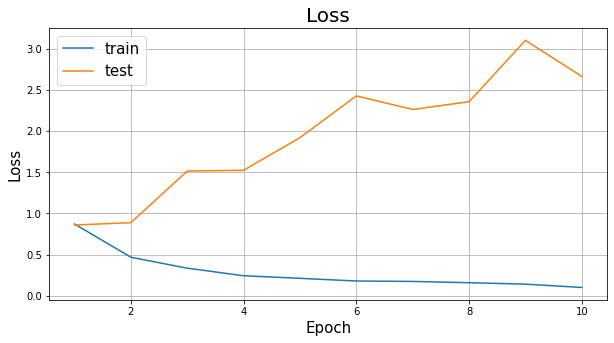

In [132]:
plt.figure(figsize = (10,5))

plt.title('Loss', fontsize = 20)
plt.grid(True)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.plot(range(1, epochs+1), train_history_loss, label='train')
plt.plot(range(1, epochs+1), test_history_loss, label='test')
plt.legend(fontsize = 15);

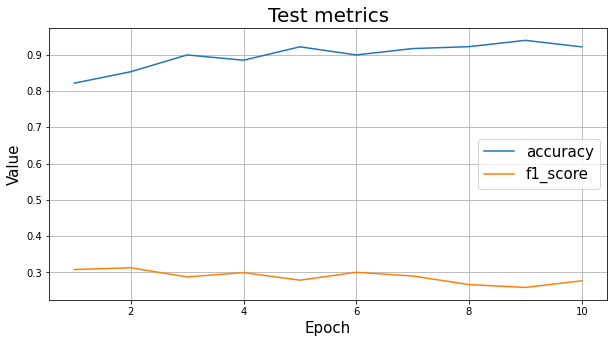

In [133]:
plt.figure(figsize = (10,5))

plt.title('Test metrics', fontsize = 20)
plt.grid(True)
plt.ylabel('Value', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.plot(range(1, epochs+1), test_history_acc, label='accuracy')
plt.plot(range(1, epochs+1), test_history_f1, label='f1_score')
plt.legend(fontsize = 15);

## 2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

Я получил довольно слабый результат - максимум 0.3 f1_score на тесте. Как бы я не менял модель, она не может уловить контекст, а ориентируется только на конекретные слова и связки слов. Train loss сходится к 0 красиво, это означает, что модель обучается правильно. Но test loss постоянно растёт, что означает, что модель не может уловить сути, обощить выводы, а затачивается под конкретные связки слов в train.

Хоть accuracy большой и растёт, но в наших данных сильный дизбаланс, поэтому эта метрика необьективна. В отличии от f1_score, на который не влияет дизбаланс классов, а так же эта метрика более чётко отражает способность модели к классификации.

Сильно улучшилась метрика, когда расширил размер словаря с 2000 до 10000, слова которые встречались от 17 до 2 раз заметно помогают модели.

Немного улучишась метрика при добавлении BatchNorm и dropout, test_loss не так быстро растёт.

Почти никак не влияет на метрику оставление/удаление (not, nor, no), мы ошиблись, предположив, что это имеет смысл в нашей задаче. Так как на уроке была задача определения эмоциональной окраски и там это имело смысл. А здесь задача нахождения hate speech и здесь это не важно, а важны ключевые слова и связки, а так же контекст, который модели явно не удалось научиться различать.